## Importing modules

In [240]:
import numpy as np
import pydicom
import glob
import matplotlib.pyplot as plt
import cv2
from read_roi import read_roi_file
from ipywidgets import interact, IntRangeSlider

## Getting dcm files

In [241]:
dir_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2AX'
files = glob.glob(dir_path + '/*.dcm')

## Reading slice

In [242]:
def rescale(im, max, min):
    return ((im.astype(float) - min) * (1. / (max - min)) * 255.).astype('uint8')


def read_slices(filename):
    name, ext = filename.split('.')

    if ext != 'dcm':
        raise ValueError('Input filename must be a DICOM file')

    slide = pydicom.dcmread(filename).pixel_array

    return slide


# ordering as istance number
z = [float(pydicom.read_file(f, force=True).get(
    "InstanceNumber", "0") - 1) for f in files]
order = np.argsort(z)
files = np.asarray(files)[order]

slice = [read_slices(f) for f in files]

Max = max([x.max() for x in slice])
Min = min([x.min() for x in slice])

slice = [rescale(x, Max, Min) for x in slice]

slice = np.asarray(slice)


### Slice info

In [243]:

depth, height, width = slice.shape
print(
    f"The image object has the following dimensions: depth:{depth}, height: {height}, width:{width}")

The image object has the following dimensions: depth:30, height: 512, width:512


# 2D Exploration

## Plotting Slice

### Random layer plot

Plotting Layer 10 of Image


(-0.5, 511.5, 511.5, -0.5)

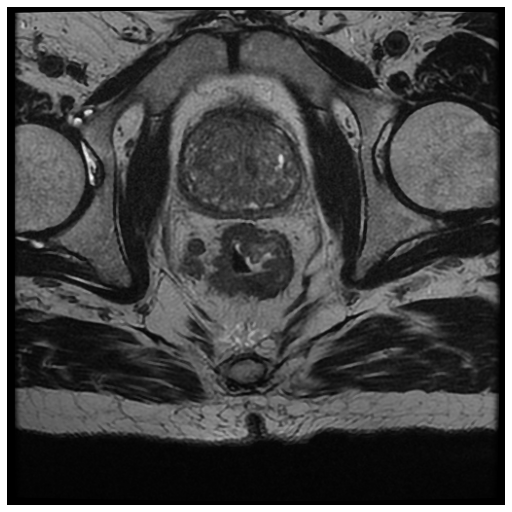

In [244]:
maxval = depth  # Select random layer number
i = np.random.randint(0, maxval)

print(f"Plotting Layer {i} of Image")

plt.figure(figsize=(12, 7), constrained_layout=True)
plt.imshow(slice[i, :, :], cmap='gray')
plt.axis('off')

### Interactive slice plot

In [245]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_slice(layer):
    plt.figure(figsize=(12, 7), constrained_layout=True)
    plt.imshow(slice[layer, :, :], cmap='gray')
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

## ROIS

### Getting ROIs

In [246]:
roi_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2ROI'
rois_list = glob.glob(roi_path + '/*.roi')


def _dict(dict_list):
    '''

    useful to get true_dict since roi is {name file : true_dict}.

    '''

    true_dict = []

    for i in dict_list:
        _dict = list(i.values())

        for j in _dict:
            keys = j.keys()
            vals = j.values()

            _dict = {key: val for key, val in zip(keys, vals)}
            true_dict.append(_dict)

    return true_dict

rois = [read_roi_file(roi) for roi in rois_list]
rois = _dict(rois)

# ordering dictionaries by positions and removing rois without x y coords
rois = sorted(rois, key=lambda d: list(d.values())[-1])
rois = list(filter(lambda d: d['type'] != 'composite', rois))

positions = []
xs = []
ys = []
for i in range(len(rois)):
    position = rois[i]['position']
    x = rois[i]['x']
    y = rois[i]['y']

    x.append(x[0])
    y.append(y[0])

    positions.append(position)
    xs.append(x)
    ys.append(y)

### Interactive ROIs plot

In [247]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_roi(layer):
    plt.figure(figsize=(12, 7))
    plt.imshow(slice[layer, :, :], cmap='gray')
    if layer in positions:
        plt.plot(xs[layer - positions[0]], ys[layer - positions[0]], color="red",
                 linestyle='dashed', linewidth=1)
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Example of ROI

10

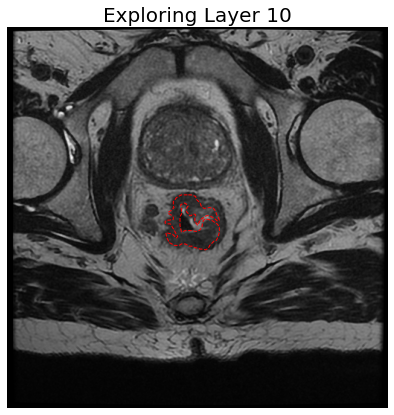

In [248]:
from random import choice 

layer = choice(positions)
explore_roi(layer=layer)

### Interactive ROIs masks

In [249]:

@interact(layer=(positions[0], positions[-1]))
def explore_mask(layer):



    image = slice[layer, :, :].copy()

    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(" ROI Mask")
    ax[1].axis('off')

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].plot(xs[layer - positions[0]],ys[layer - positions[0]] , color="red",
                linestyle='dashed', linewidth=1)
    ax[0].set_title("ROI")
    ax[0].axis('off')

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)


interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of ROI mask

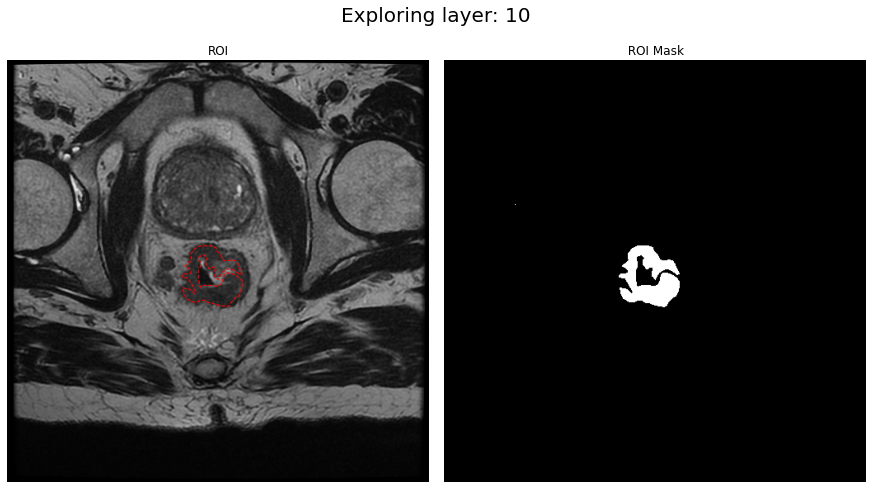

In [250]:
explore_mask(layer=layer)

### Appling ROIs Mask

In [251]:

@interact(layer=(positions[0], positions[-1]))
def explore_masked_image(layer):
    
    image = slice[layer, :, :].copy()

    
    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    masked_img = cv2.bitwise_and(slice[layer, :, :].copy(), image, mask = mask)

    fig, ax = plt.subplots(1, 3, figsize=(12, 7), constrained_layout=True)

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis('off')

    
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("ROI Mask")
    ax[1].axis('off')

    ax[2].imshow(masked_img, cmap="gray")
    ax[2].set_title("Applied ROI mask")
    ax[2].axis('off')
    fig.suptitle(f'Exploring layer {layer}', fontsize=20)
        

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of applied mask

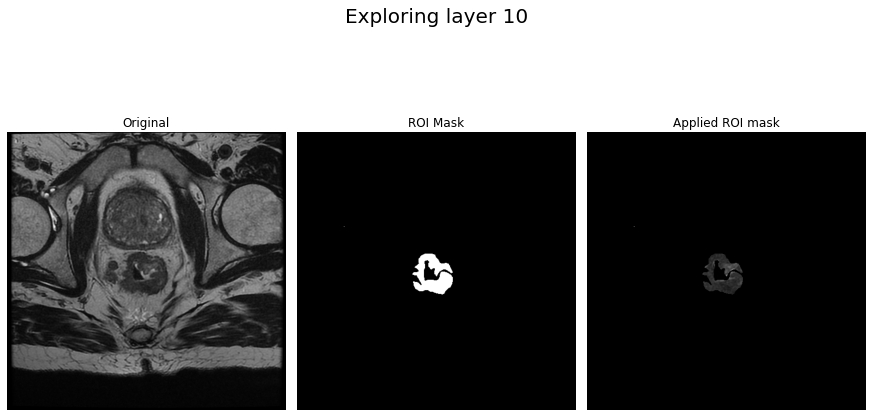

In [252]:
explore_masked_image(layer=layer)

# Traditional image processing segmentation

### Exploring histogram

In [253]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_histogram(layer):

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True) 

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256, [0,256], color="black")
    ax[1].set_title("Histogram")

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example 

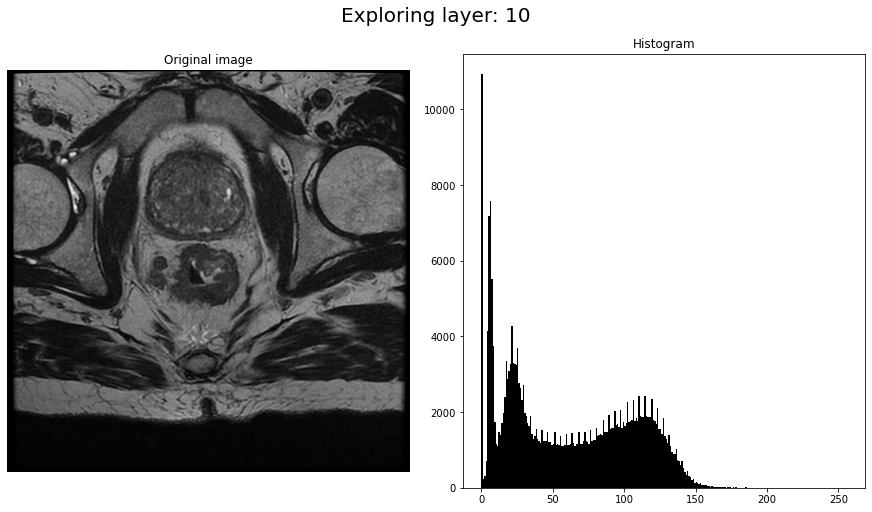

In [254]:
explore_histogram(layer=layer)

### Histogram Global Thresholding

In [255]:
@interact(layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,255], min=0, max=255, step=1, ) )
def manual_tresh(layer, threshold):

    image = slice[layer, : ,:].copy()


    t_min = threshold[0]
    t_max = threshold[1]
    

    mask = cv2.threshold(image, t_min, t_max, cv2.THRESH_BINARY_INV)[1]




    fig, ax=plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True) 


    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256,[0,256], color="black")
    ax[1].set_title("Histogram")
    ax[1].vlines(t_min,0, 10000, color="red", linestyle="dashed")
    ax[1].vlines(t_max,0, 10000, color="red", linestyle="dashed")
    ax[1].text(t_min, 10000, "$T_{min}$")
    ax[1].text(t_max, 10000, "$T_{max}$")
    ax[1].set_yticks([])
    


    ax[2].imshow(mask, cmap="gray")
    ax[2].set_title("Thresholded Image")
    ax[2].axis("off")



    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)

    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 255), descri…

### Non interactive example

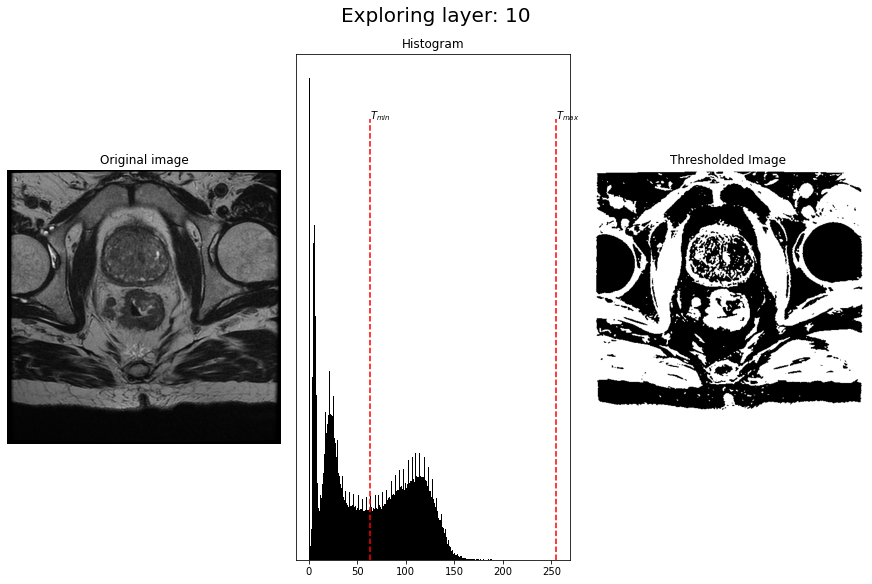

In [256]:
manual_tresh(layer=layer, threshold=(63, 255))

### Adaptive Threshold methods

Text(0.5, 0.98, 'Exploring layer: 10')

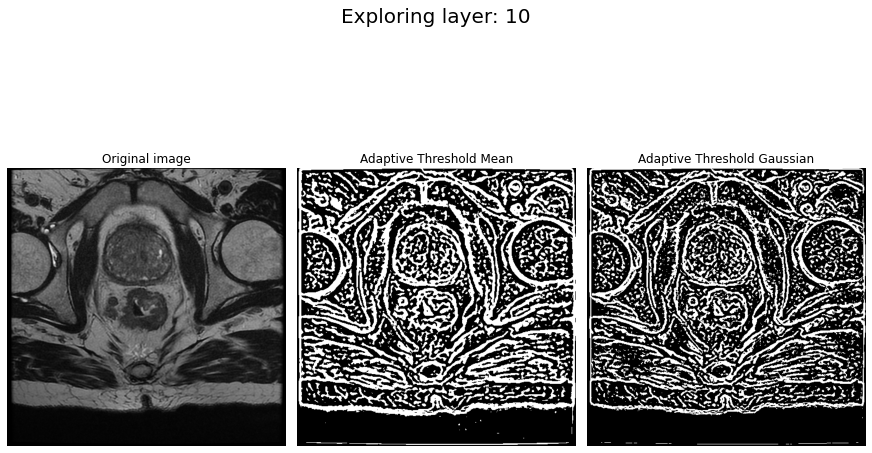

In [257]:

img = image = slice[layer, : ,:].copy()
blur = cv2.medianBlur(img,ksize=5)

th = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
th2 = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

fig, ax = plt.subplots(1, 3, figsize=(12,8), constrained_layout=True)

ax[0].imshow(img, "gray")
ax[0].axis("off")
ax[0].set_title("Original image")

ax[1].imshow(th, "gray")
ax[1].axis("off")
ax[1].set_title("Adaptive Threshold Mean")

ax[2].imshow(th2, "gray")
ax[2].axis("off")
ax[2].set_title("Adaptive Threshold Gaussian")

fig.suptitle(f'Exploring layer: {layer}', fontsize=20)

### Otsu

In [258]:
    
 @interact(layer=(0, slice.shape[0] - 1))   
def otsu_thresholding(layer):   

    img = slice[layer, : ,:].copy()
    gauss = cv2.GaussianBlur(img, (5, 5), 0)

    t_min = 0
    t_max = 255

    thresh_otsu = cv2.threshold(gauss,t_min, t_max,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(slice[layer, : ,:], cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(thresh_otsu, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Otsu")

    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example

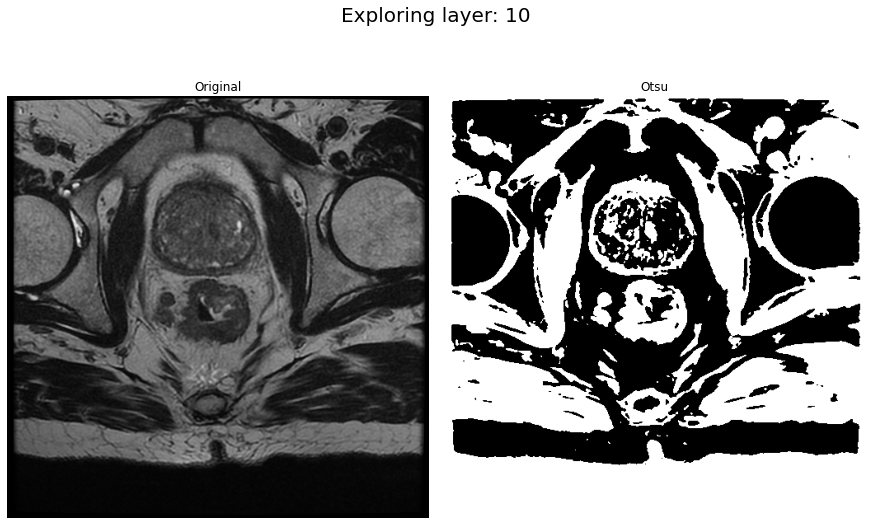

In [259]:
 otsu_thresholding(layer=layer)

### Boxed Masks

In [260]:

@interact(layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def box_fov(layer, threshold):


    img = slice[layer, : ,:].copy()
    box = np.zeros(img.shape[:2], np.uint8)
    box[150:350, 150:350] = 255

    boxed_original = cv2.bitwise_and(img,img,mask = box)

    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(img, t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 256,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)

   
    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(boxed_original, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    


interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 120), descri…

### Non interactive example

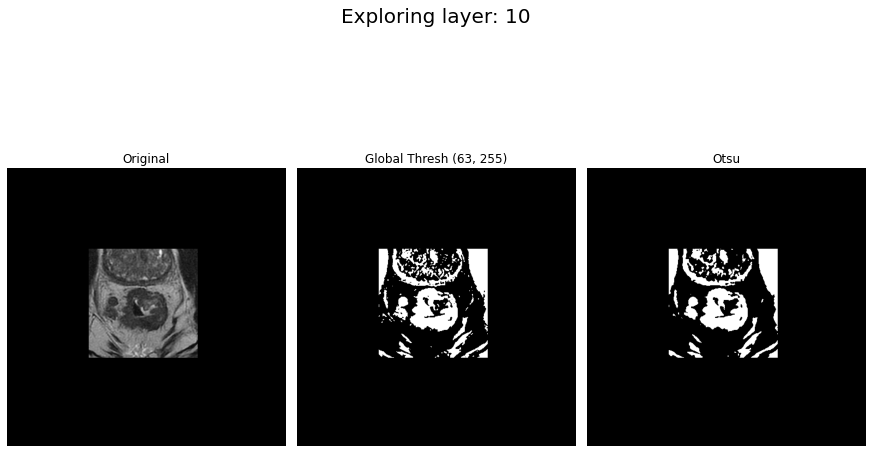

In [261]:
box_fov(layer=layer, threshold=(63, 255))

### Comparing masks

In [262]:
@interact(layer=(positions[0], positions[-1]), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def comparing_masks(layer, threshold):

    image = slice[layer, : ,:].copy()
    box = np.zeros(image.shape[:2], np.uint8)
    box[150:350, 150:350] = 255


    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    true_mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]


    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(slice[layer, : ,:].copy(), t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(slice[layer, : ,:].copy(), (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)


    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(true_mask, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Ground truth")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title("Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), IntRangeSlider(value=(63, 120),…

### Non interactive Example

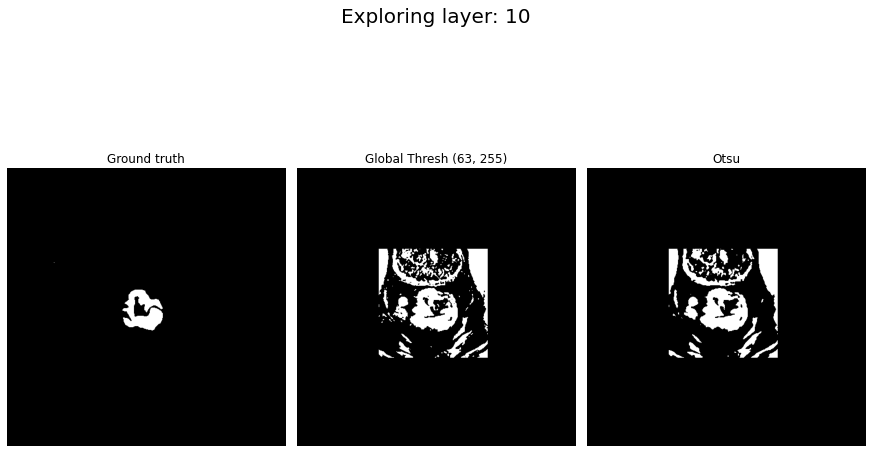

In [263]:
comparing_masks(layer=layer, threshold=(63, 255))

### Gabor filters

Text(0.5, 0.98, 'Exploring layer: 16')

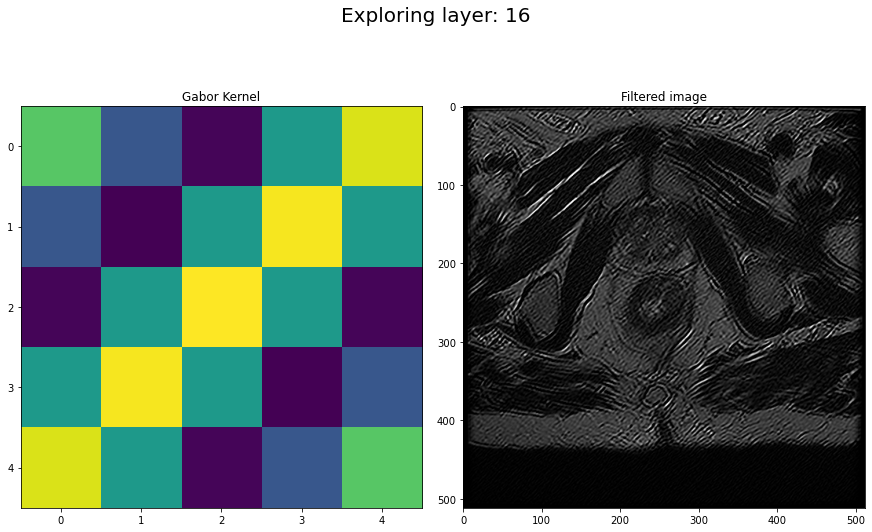

In [264]:

ksize = 5
sigma = 3
theta = 1*np.pi/4
lamb = 4*np.pi/4
gamma = 0.5
phi = 0

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

layer = 16
img = slice[layer, :, :].copy()

filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

fig, ax = plt.subplots(1, 2, figsize=(12, 8 ), constrained_layout=True)

ax[0].imshow(kernel)
ax[0].set_title("Gabor Kernel")

ax[1].imshow(filtered_img, cmap="gray")
ax[1].set_title("Filtered image")
fig.suptitle(f'Exploring layer: {layer}', fontsize=20)

### Denoising with Non Local Means filter

Text(0.5, 1.0, 'after NLM denoise')

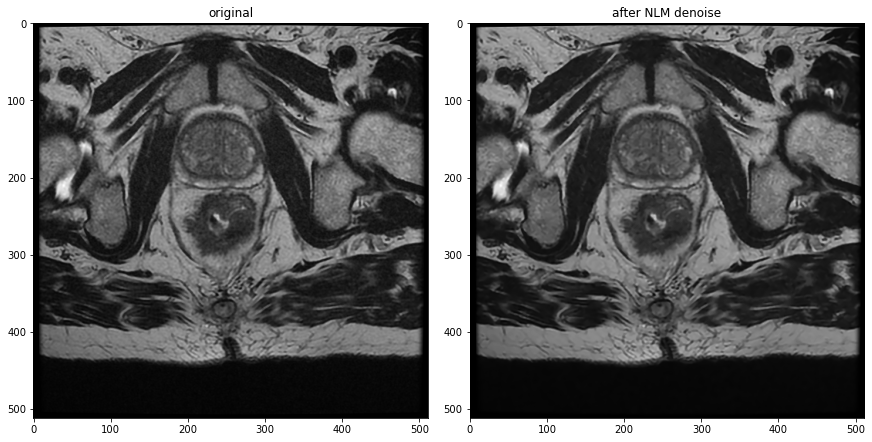

In [265]:
from skimage.restoration import denoise_nl_means, estimate_sigma

layer = 14
img = slice[layer, :, :].copy()

sigma = np.mean(estimate_sigma(img, multichannel=False))

alpha = 4
denoise_img = denoise_nl_means(img, h=alpha*sigma, patch_size=5, patch_distance=3, multichannel=False, preserve_range=True)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(img, cmap="gray")
ax[0].set_title("original")

ax[1].imshow(denoise_img, cmap="gray")
ax[1].set_title("after NLM denoise")

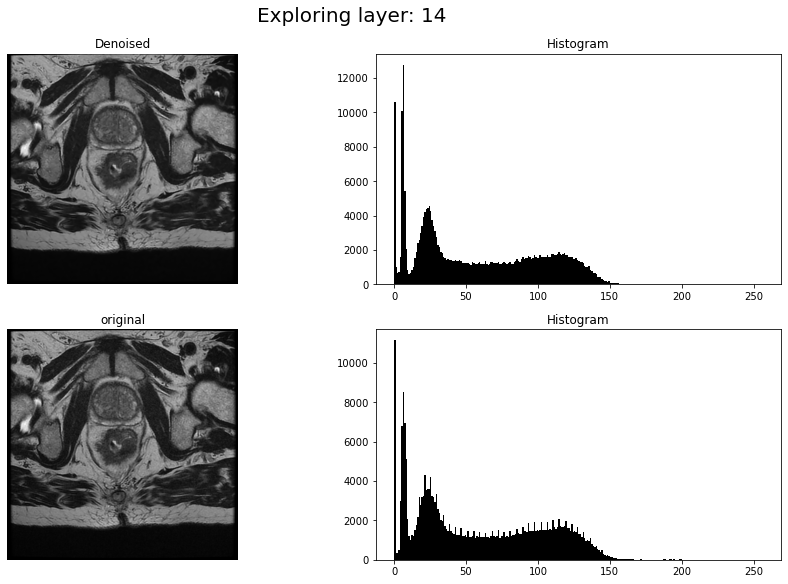

In [266]:
fig, ax=plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True) 

ax[0][0].imshow(denoise_img, cmap="gray")
ax[0][0].set_title("Denoised")
ax[0][0].axis("off")


ax[0][1].hist(denoise_img.ravel(),256, [0,256], color="black")
ax[0][1].set_title("Histogram")

ax[1][0].imshow(img, cmap="gray")
ax[1][0].set_title("original")
ax[1][0].axis("off")

ax[1][1].hist(img.ravel(),256, [0,256], color="black")
ax[1][1].set_title("Histogram")

fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
plt.show()

# Machine Learning Approach

## Importing modules for ML 

In [267]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


## Feature extraction

### Labels

In [268]:
def make_labels(slice, layer):

    if not layer in positions:
        print("no labels found!")
        

    else:
        #create layers from given ROI points
        image = slice[layer, :, :].copy()

        
        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        label = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

        return label

In [269]:
def features_extraction(slice, layer, ksize, Train_mode=False):

    df = pd.DataFrame() # create dataframe for features


    img = slice[layer, :, :].copy()

    img_vect = img.reshape(-1) # reshape 2D image into 1D vector
    df['Original pixels'] = img_vect 


    #generate a bunch of Gabor filters  
    i = 1 
    for theta in np.arange(0, 2 * np.pi, np.pi/4):
        for sigma in np.arange(1, 5, 1):
            for lamb in np.arange(0, 2 * np.pi, np.pi/4):
                for gamma in np.arange(0,1, 0.5):
                    for phi in np.arange(0,1, 0.5):
                        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        
                        fimg_vect = fimg.reshape(-1)

                        Gabor_label = "Gabor" + str(i)
                        df[Gabor_label] = fimg_vect

                        i += 1



                        
    if Train_mode:

        labels = make_labels(slice=slice, layer=layer)
        labels_vect = labels.reshape(-1)
        df['labels'] = labels_vect

    return df


df = features_extraction(slice=slice, layer=14, ksize=5, Train_mode=True)



## Defining Variables

In [270]:
Y = df['labels'].values
X = df.drop(labels= ['labels'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=20)

## Random Forest Classifier

In [271]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))


Accuracy =  0.9837385968545302


### confusion matrix

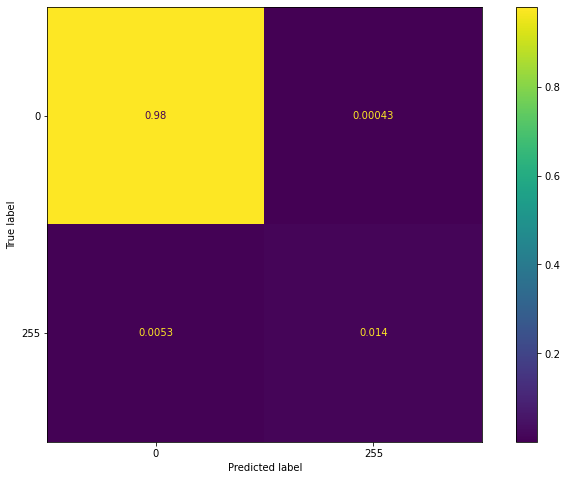

In [272]:
conf_matrix = metrics.confusion_matrix(Y_test, prediction_test, normalize='all')

fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, X, Y, normalize='all', ax=ax)
plt.show() 

### Most relevant filters

In [273]:

features_list = list(X.columns)
features_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

pd.options.display.float_format = '{:,.10f}'.format
print(features_imp)


t = 0.0005
print('\n', f'Greater than {t}', '\n\n', features_imp[features_imp > t])

Gabor304   0.0082429749
Gabor336   0.0074289747
Gabor846   0.0074139516
Gabor112   0.0068637475
Gabor366   0.0067408659
               ...     
Gabor585   0.0000000000
Gabor586   0.0000000000
Gabor812   0.0000000000
Gabor811   0.0000000000
Gabor740   0.0000000000
Length: 1025, dtype: float64

 Greater than 0.0005 

 Gabor304   0.0082429749
Gabor336   0.0074289747
Gabor846   0.0074139516
Gabor112   0.0068637475
Gabor366   0.0067408659
               ...     
Gabor441   0.0005345493
Gabor31    0.0005310544
Gabor30    0.0005081111
Gabor672   0.0005065596
Gabor635   0.0005028729
Length: 588, dtype: float64


## Pickling model

In [274]:
import pickle

filename = 'RF_model'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

## Test model predictions 

### Loading model

In [275]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

### Test on trained image

Text(0.5, 1.0, 'ground truth')

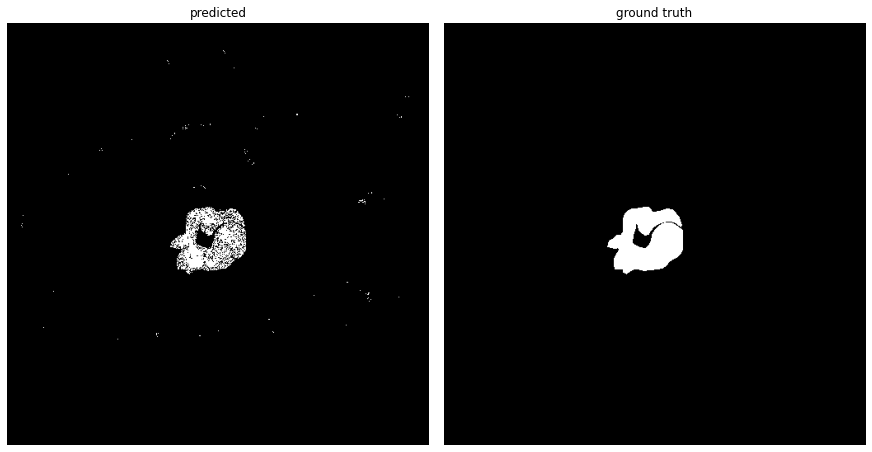

In [276]:
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=slice, layer=14)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")


### Test on different image

Text(0.5, 1.0, 'ground truth')

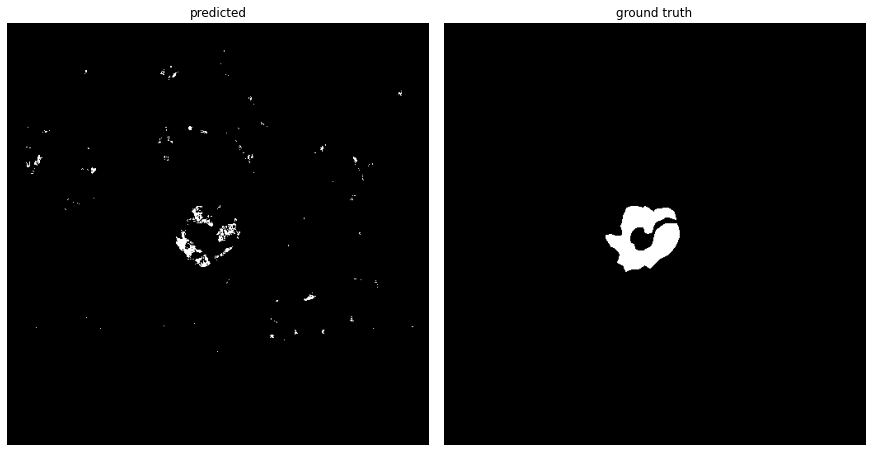

In [277]:
layer = 15

X_2 = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)


result_2 = load_model.predict(X_2)

segmented_2 = result_2.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented_2, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img_2 = make_labels(slice=slice, layer=layer)

ax[1].imshow(label_img_2, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")

## Multi-image Training

### Features extraction

In [278]:

df_ = features_extraction(slice=slice, layer=14, ksize=5, Train_mode=True)
df_1 = features_extraction(slice=slice, layer=15, ksize=5, Train_mode=True)


multi_df = pd.concat([ df_, df_1])



### Defining Variables

In [279]:
YY = multi_df['labels'].values
XX = multi_df.drop(labels= ['labels'], axis=1)

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.25, random_state=20)

### ML Model

In [280]:
model = RandomForestClassifier(n_estimators=80, random_state=42)

model.fit(XX_train, YY_train)

prediction_test = model.predict(XX_test)
print("Accuracy = ", metrics.accuracy_score(YY_test, prediction_test))

Accuracy =  0.9854507446289062


### Most relevant features

In [281]:
features_list = list(XX.columns)
features_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

pd.options.display.float_format = '{:,.10f}'.format
print(features_imp)

t = 0.0005
print('\n', f'Greater than {t}', '\n\n', features_imp[features_imp > t])

Gabor336   0.0097513921
Gabor848   0.0070565660
Gabor334   0.0069881826
Gabor48    0.0067038524
Gabor302   0.0065096573
               ...     
Gabor357   0.0000000000
Gabor161   0.0000000000
Gabor812   0.0000000000
Gabor811   0.0000000000
Gabor420   0.0000000000
Length: 1025, dtype: float64

 Greater than 0.0005 

 Gabor336   0.0097513921
Gabor848   0.0070565660
Gabor334   0.0069881826
Gabor48    0.0067038524
Gabor302   0.0065096573
               ...     
Gabor415   0.0005446453
Gabor285   0.0005427361
Gabor222   0.0005389888
Gabor31    0.0005038324
Gabor441   0.0005037355
Length: 587, dtype: float64


### Confusion Matrix

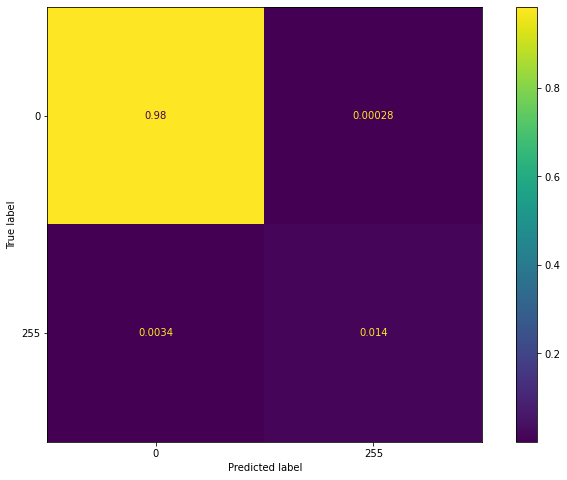

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, XX, YY, normalize='all', ax=ax)
plt.show() 

### saving model

In [283]:
filename = 'RF_model_multi'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

### loading model

In [284]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

### Test on trained image

Text(0.5, 1.0, 'ground truth')

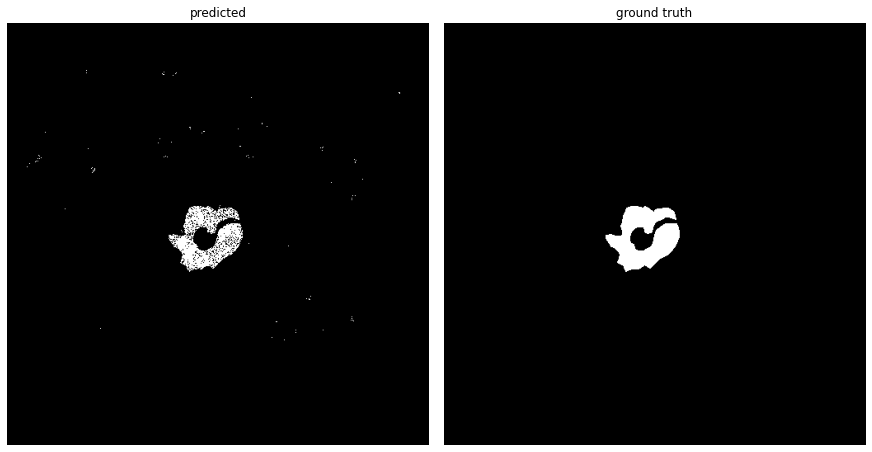

In [285]:
layer = 15

X = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=slice, layer=layer)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")

### Test on different image

Text(0.5, 1.0, 'ground truth')

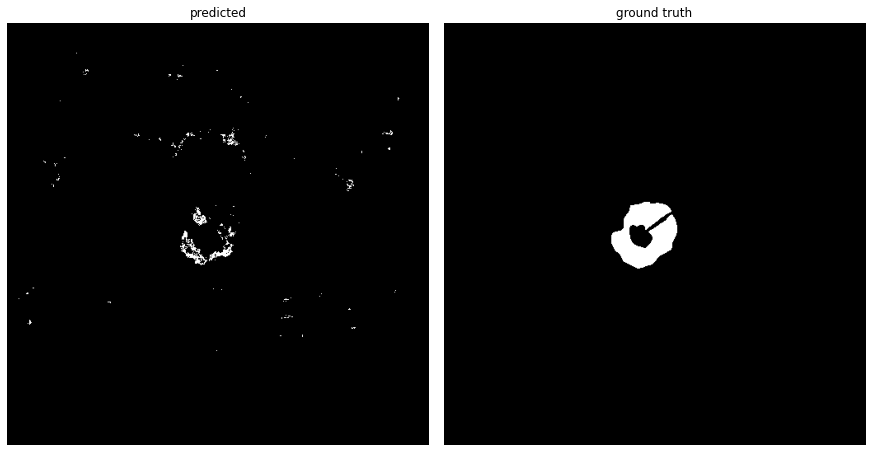

In [286]:
layer = 16

X = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=slice, layer=layer)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")

## Training on denoised images

### pre-processing

In [287]:
def denoise_slice(slice, alpha, patch_size, patch_distance):

    denoised_slice = np.zeros_like(slice)

    for layer in range(slice.shape[0]):

        img = slice[layer, :, :].copy()

        sigma = np.mean(estimate_sigma(img, multichannel=False))

        
        denoised_img = denoise_nl_means(img, h=alpha*sigma, patch_size=patch_size, patch_distance=patch_distance, multichannel=False, preserve_range=True)

        denoised_slice[layer, : ,:] = denoised_img

        



    return denoised_slice


In [288]:
denoised_slice = denoise_slice(slice=slice, alpha=4, patch_size=5, patch_distance=3)

In [289]:
denoised_slice.shape

(30, 512, 512)

### features extraction

In [290]:
df = features_extraction(slice=denoised_slice, layer=14, ksize=5, Train_mode=True)

### Defining variables

In [291]:
Y = df['labels'].values
X = df.drop(labels= ['labels'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=20)

### RandomForestClassifier

In [292]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))

Accuracy =  0.9851772732722259


### Confusion matrix

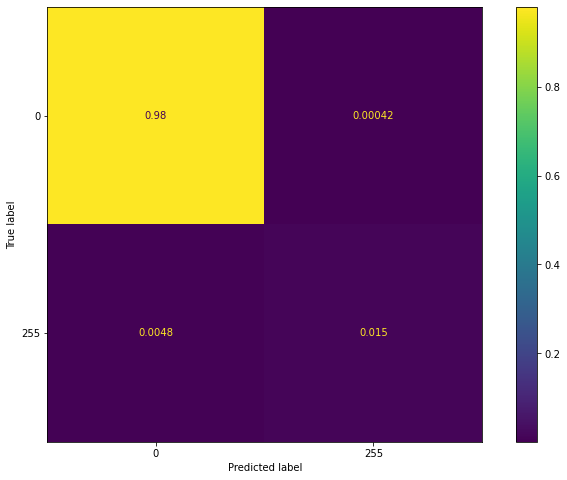

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, X, Y, normalize='all', ax=ax)
plt.show() 

### Saving model

In [294]:
filename = 'RF_model_denoised'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

### Loading model

In [295]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

## Test on trained image

Text(0.5, 1.0, 'ground truth')

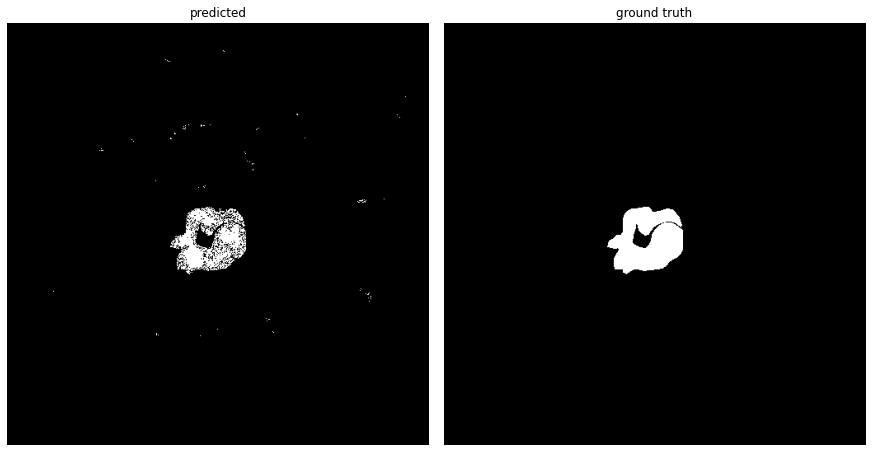

In [296]:
layer = 14

X = features_extraction(slice=denoised_slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=denoised_slice, layer=layer)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")

## Test on different image

Text(0.5, 1.0, 'ground truth')

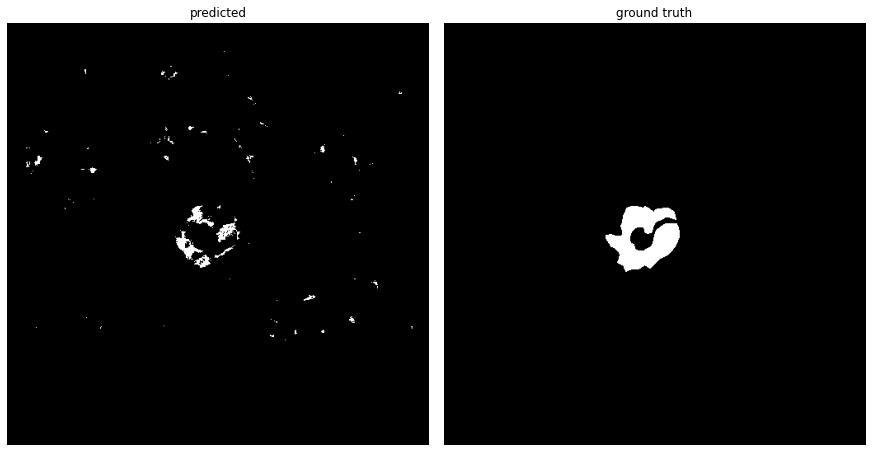

In [297]:
layer = 15

X = features_extraction(slice=denoised_slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=denoised_slice, layer=layer)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")